# Scikit-Learn ve Boosting

Boosting yöntemlerinden AdaBoost ve Gradient Boosting `scikit-learn` altında da bulunuyor. `Scikit-learn` uçtan uca çözüm sunan bir paket olduğu için boosting uygulamalarında daha fazla esneklik için `LightGBM` ya da `xgboost` gibi paketleri tercih etmekte fayda var. Ancak bu paketleri kullansanız da veriyi işlemek, sonuçları değerlendirmek için `scikit-learn` ideal bir çözüm sunuyor. 

Şimdi `scikit-learn` altındaki boosting yöntemlerinin kullanımını UCI dizinindeki [banka pazarlama veri kümesi](https://archive.ics.uci.edu/ml/datasets/bank+marketing) üzerinden inceleyelim. Elimizdeki problem iki sınıftan oluşan bir sınıflandırma problemi. Amaç müşterilerin özelliklerine ve ekonomik göstergelere bakarak müşterilerin kampanya tekliflerine dönüş yapıp yapmayacağını tahmin etmek. 

Paketleri yükleyerek ve veri kümesini okuyarak başlayalım.

In [1]:
# Veri çerçevesi oluşturmak için Pandas paketini kullanıyoruz.
import pandas as pd
# Veri kümesini ikiye bölmek ve performans ölçütlerinin hesaplanması için gerekli modüller.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# Grafik çizdirmek için gerekli paket.
import matplotlib.pyplot as plt
import numpy as np
#Uyarı mesajlarını kapatmak için
import warnings
warnings.filterwarnings("ignore")
# Veri çerçevelerini daha güzel görselleştirmek için
from IPython.display import display, HTML
# Veri kümesini okuyalım ve etiketleri ayıralım. Veri çerçevesindeki sütun isimlerini de değiştiriyoruz.
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
y= (df['y'] == 'yes')*1
df.drop('y', axis=1, inplace = True)

df.columns = ['yaş', 'iş', 'medeni_durum', 'eğitim', 'gecikme', 'ev', 'borç', 'iletişim', 'ay', 'haftanın_günü',
              'süre', 'kampanya', 'önceki_iletişimden_sonra_geçen_gün', 'iletişim_sayısı', 'iletişim_sonucu', 
              'işsizlik', 'tüketici_fiyat_endeksi', 'tüketici_güven_endeksi', 'euribor_faizi', 'çalışan_sayısı'] 
print(df.head())

   yaş         iş medeni_durum       eğitim  gecikme   ev borç   iletişim  \
0   56  housemaid      married     basic.4y       no   no   no  telephone   
1   57   services      married  high.school  unknown   no   no  telephone   
2   37   services      married  high.school       no  yes   no  telephone   
3   40     admin.      married     basic.6y       no   no   no  telephone   
4   56   services      married  high.school       no   no  yes  telephone   

    ay haftanın_günü  süre  kampanya  önceki_iletişimden_sonra_geçen_gün  \
0  may           mon   261         1                                 999   
1  may           mon   149         1                                 999   
2  may           mon   226         1                                 999   
3  may           mon   151         1                                 999   
4  may           mon   307         1                                 999   

   iletişim_sayısı iletişim_sonucu  işsizlik  tüketici_fiyat_endeksi  \
0       

Verideki değişkenlerin anlamlarını aşağıda ve veri kümesini indirebileceğiniz [web sayfasında](https://archive.ics.uci.edu/ml/datasets/bank+marketing) bulabilirsiniz:
* yaş: Müşterinin yaşı.
* iş: Müşterinin işinin tanımı.
* medeni_durum: Müşterinin medeni durumu.
* eğitim: Müşterinin eğitim durumu.
* gecikme: Borcunu ödemekte gecikme yaşadığı kredi var mı?
* ev: Ev kredisi ödüyor mu?
* borç: Başka kredi ödüyor mu?
* iletişim: İletişim için seçtiği telefon tipi (sabit hat, GSM).
* ay: En son iletişim kurulan ay.
* haftanın_günü: En son iletişim kurulan gün (haftanın günü olarak). 
* süre: En son iletişim kurulan süre. Bu değişken 0 değerini aldığında etiket de 0 (ya da `no`) değerini aldığı için sağlıklı bir analiz için bu değişkeni veri kümesinden çıkarıyoruz.
* kampanya: Müşteri için bu kampanya özelinde kaç kere iletişim kurulduğu bilgisi.
* önceki_iletişimden_sonra_geçen_gün: Müşteriyle başka bir kampanya için iletişim kurulan günden bu yana geçen zaman. Değer 999 ise iletişim kurulmadığı anlamına geliyor. 
* iletişim_sayısı: Müşteriyle bu kampanya öncesi kurulan iletişim sayısı.
* iletişim_sonucu: Önceki kampanya iletişiminin sonucu.                     
* işsizlik: İşsizlik endeksindeki değişim.
* tüketici_fiyat_endeksi: Tüketici fiyat endeksi.
* tüketici_güven_endeksi: Tüketici güven endeksi.
* euribor_faizi: Euribor faizi (Euro Interbank Offered Rate).
* çalışan_sayısı: Çalışan nüfus sayısı.

Gördüğümüz gibi son beş değişken daha çok sosyal ve ekonomik göstergelerden oluşuyor. Bu göstergeler kampanya teklifinin yapıldığı zamana ait değerleri içeriyor. Veri kümesinde eksik değerler olup olmadığını inceleyelim.

In [2]:
print(df.isnull().sum())

yaş                                   0
iş                                    0
medeni_durum                          0
eğitim                                0
gecikme                               0
ev                                    0
borç                                  0
iletişim                              0
ay                                    0
haftanın_günü                         0
süre                                  0
kampanya                              0
önceki_iletişimden_sonra_geçen_gün    0
iletişim_sayısı                       0
iletişim_sonucu                       0
işsizlik                              0
tüketici_fiyat_endeksi                0
tüketici_güven_endeksi                0
euribor_faizi                         0
çalışan_sayısı                        0
dtype: int64


Veri kümesinde eksik değer yok. Aslında bilinmeyen (`unknown`) gibi değerler mevcut. Ayrıca `önceki_iletişimden_sonra_geçen_gün` değişkeni de 999 değerini aldığında bu değişkenin tanımlı olmadığı duruma denk geliyor. Şimdilik eksik değerlere odaklanmayalım. 

Veri kümesinde eksik değer bulunmasa da, kategorik değişkenler bulunmakta. Örnek olarak `iş` sütununu inceleyelim.

In [3]:
df['iş'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

Kategorik değişkenleri sayısal hale getirmemiz gerekiyor. Bu amaçla `scikit-learn` paketindeki `LabelEncoder` modülünü kullanabiliriz. Bahsettiğim modül değişkenleri 0 ve değer sayısı - 1 (bu örnekte 12 ayrı değer olduğu için 11) arasındaki sayılara çevirecek. Örnek olarak `housemaid` 0 değerini alırken `student` 11 değerini alacak. Kategorik değişkenleri 0 ve 1 değerleri alan kukla değişkenlere çevirmek için `LabelBinarizer` modülünü kullanabilirsiniz. Ben `LightGBM` ile tutarlı olması için `LabelEncoder` kullandım; ancak `scikit-learn` kategorik değişkenleri özel olarak değerlendirmediği için `LabelBinarizer` kullanmamız daha doğru olacaktır.

Veri kümesindeki kategorik değişkenleri sayısal hale getirelim.

In [4]:
from sklearn.preprocessing import LabelEncoder

kategorik_sutunlar = ['iş', 'medeni_durum', 'eğitim', 'gecikme', 'ev', 'borç', 'iletişim', 'ay',
                      'haftanın_günü', 'iletişim_sonucu']

for i in kategorik_sutunlar:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])
print(df.head())

   yaş  iş  medeni_durum  eğitim  gecikme  ev  borç  iletişim  ay  \
0   56   3             1       0        0   0     0         1   6   
1   57   7             1       3        1   0     0         1   6   
2   37   7             1       3        0   2     0         1   6   
3   40   0             1       1        0   0     0         1   6   
4   56   7             1       3        0   0     2         1   6   

   haftanın_günü  süre  kampanya  önceki_iletişimden_sonra_geçen_gün  \
0              1   261         1                                 999   
1              1   149         1                                 999   
2              1   226         1                                 999   
3              1   151         1                                 999   
4              1   307         1                                 999   

   iletişim_sayısı  iletişim_sonucu  işsizlik  tüketici_fiyat_endeksi  \
0                0                1       1.1                  93.994   
1     

Burada şunu belirtmem gerekiyor. Yaptığımız dönüşüm işlemini geri dönüşsüz olarak yaptık. Yani dönüştürdüğümüz kolonlardaki değerleri kaybettik. Veri kümesinin orijinal versiyonuyla bir eşleştirme yaparak bu değerleri tekrar elde edebiliriz. Eski değerleri koruyarak bu değişimi yapmak `scikit-learn` ile biraz daha zor bir işlem ve bu yazının konusunun dışında. Ancak [derin kopyalama](http://www.veridefteri.com/2018/03/19/python-programlamaya-giris-18-python-referans-modeli-sig-ve-derin-kopyalama/) ile veri çerçevesinin orijinalinin bir kopyasını oluşturmak mümkün.

Veri kümesini analize uygun hale getirdiğimize göre eğitim ve sınama için ikiye bölelim ve `süre` değişkenini kümeden çıkartalım.

In [5]:
df.drop('süre', inplace = True, axis=1)
df_train, df_test, y_train, y_test = train_test_split(df, y, train_size = 0.7, test_size = 0.3)

# Model Eğitme

`scikit-learn` altındaki AdaBoost ve Gradient Boosting yöntemlerini kullanarak tahmin yapalım. `scikit-learn` API'ındaki `fit/predict` ve `fit/transform` yapısı, modelleri eğitmeyi çok kolaylaştırıyor. Ben, modelleri eğitmek için varsayılan değerleri kullandım. Ancak özellikle iterasyon sayısı (`n_estimators`) gibi değişkenlerle denemeler yapmak yararlı olabilir.

In [6]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#Tek seviyeli karar ağaçlarıyla AdaBoost modeli oluşturalım.
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), random_state=0)

# Modeli eğitip, sonuçlarını alalım.
ada.fit(df_train, y_train)
y_pred_ada = ada.predict(df_test)
y_pred_proba_ada = ada.predict_proba(df_test)

# Bir Gradient Boosting modeli oluşturalım.
gbc = GradientBoostingClassifier(random_state=0)

# Modeli eğitip, sonuçlarını alalım.
gbc.fit(df_train, y_train)
y_pred_gbc = gbc.predict(df_test)
y_pred_proba_gbc = gbc.predict_proba(df_test)

Şimdi eğittiğimiz modelin başarısına bakalım. Bu amaçla eğri altı alan, hata matrisi ve isabetlilik değerlerine bakalım.

In [7]:
# Tahmin ve değerlendirme

print('AdaBoost')
print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred_proba_ada[:,1]))
print('İsabetlilik değeri:', accuracy_score(y_test, y_pred_ada))
print('Hata matrisi:\n', confusion_matrix(y_test, y_pred_ada))

print('Gradient Boosting')
print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred_proba_gbc[:,1]))
print('İsabetlilik değeri:', accuracy_score(y_test, y_pred_gbc))
print('Hata matrisi:\n', confusion_matrix(y_test, y_pred_gbc))


AdaBoost
Eğri altı alan değeri: 0.800718324303
İsabetlilik değeri: 0.901189609128
Hata matrisi:
 [[10839   132]
 [ 1089   297]]
Gradient Boosting
Eğri altı alan değeri: 0.804200711228
İsabetlilik değeri: 0.902565347576
Hata matrisi:
 [[10794   177]
 [ 1027   359]]


Gradient Boosting biraz daha başarılı oldu. Ancak arada çok belirgin bir fark yok gibi. Karar alıcı durumundaki birisi için müşterilerin kampanyaya cevap verip/vermeyecek olması kadar bunun ihtimali de önemli olabilir. Örnek olarak bir kullanıcı kampanyaya cevap verme ihtimali %80'in üzerindeki müşterilerle ilgilenmeyi tercih edebilir. Müşterilerin kampanyaya cevap verme ihtimallerine daha yakından bakalım. Olasılıkları incelemek amacıyla iki histogram çizdireceğiz.

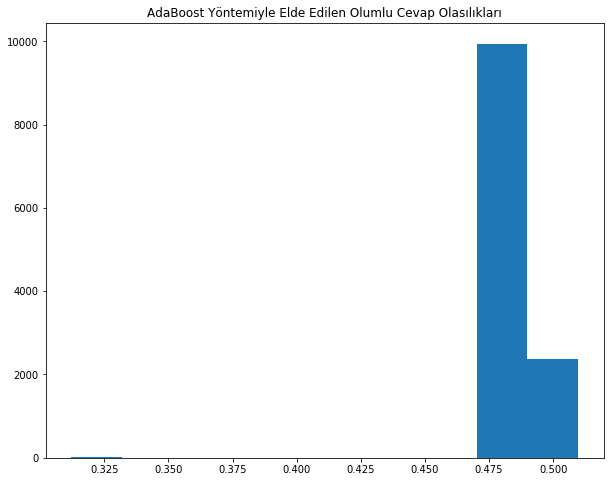

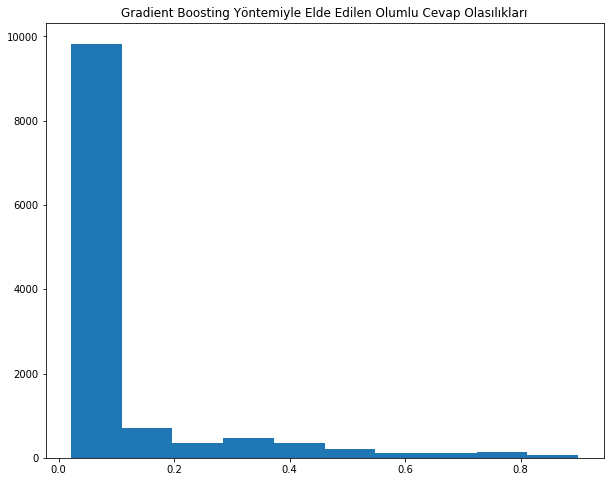

In [8]:
plt.figure(figsize=(10,8))
plt.title('AdaBoost Yöntemiyle Elde Edilen Olumlu Cevap Olasılıkları')
plt.hist(y_pred_proba_ada[:,1], bins=10)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Gradient Boosting Yöntemiyle Elde Edilen Olumlu Cevap Olasılıkları')
plt.hist(y_pred_proba_gbc[:,1], bins=10)
plt.show()

# Kalibrasyon

Tek başına rakamların çok fazla bir şey ifade etmediğini görmüş olduk. AdaBoost performans olarak Gradient Boostinge yakın gözükse de kullanımı daha zor. Kampanyaya cevap verme olasılığı en yüksek olan müşteri için bile bu olasılık %55 civarında.

AdaBoost yönteminde gördüğümüz kadarıyla olasılıkların değerlerinin anlamı az. Ancak müşteriler olasılıklara göre sıralandığında bu sıralama başarılıdır diyebiliriz (eğri altı değerin yüksekliği nedeniyle). 

AdaBoost (ve diğer sınıflandırma algoritmalarıyla) elde edilen olasılıkların kullanılabilirliğini arttırmak için olasılıkların yeniden değerlendirilmesi ve dönüştürülmesi gerekli olabilir. `scikit-learn` altındaki `CalibratedClassifierCV` tam olarak bunu yapıyor.

Kalibrasyona geçmeden önce çizdirdiğimiz histogramı detaylandıralım.

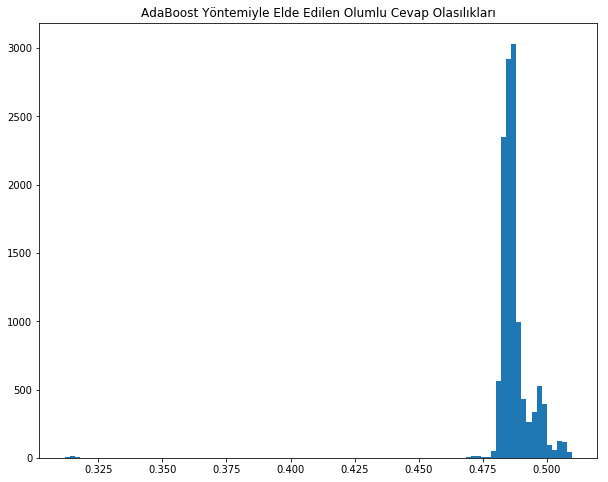

In [9]:
plt.figure(figsize=(10,8))
plt.title('AdaBoost Yöntemiyle Elde Edilen Olumlu Cevap Olasılıkları')
plt.hist(y_pred_proba_ada[:,1], bins=100)
plt.show()

Aslında müşterilerin kampanyaya cevap verme olasılıklarının bir dağılımı var. Yapacağımız kalibrasyon işlemi, bu değerleri 0 ile 1 arasında daha geniş bir aralığa dönüştürecek.

Calibrated AdaBoost
Eğri altı alan değeri: 0.80077915633
İsabetlilik değeri: 0.901270534919
Hata matrisi:
 [[10846   125]
 [ 1095   291]]


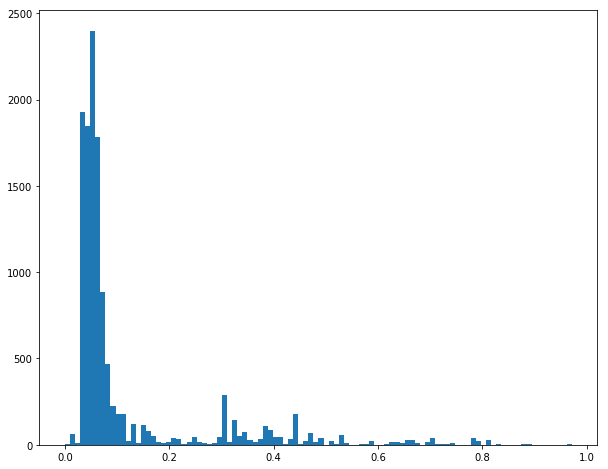

In [10]:
from sklearn.calibration import CalibratedClassifierCV

# Kalibrasyon fonksiyonları için scikit-learn dokümantasyonunu inceleyebilirsiniz.
# http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html 
# Modeli eğitmek için kalibrasyon yapacağımız modeli de belirtiyoruz. Onun dışında kullandığımız fonksiyonlar aynı.
cclf = CalibratedClassifierCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), random_state=0), method= 'isotonic')

cclf.fit(df_train,y_train)
y_pred_cclf = cclf.predict(df_test)
y_pred_proba_cclf = cclf.predict_proba(df_test)

print('Calibrated AdaBoost')
print('Eğri altı alan değeri:', roc_auc_score(y_test, y_pred_proba_cclf[:,1]))
print('İsabetlilik değeri:', accuracy_score(y_test, y_pred_cclf))
print('Hata matrisi:\n', confusion_matrix(y_test, y_pred_cclf))

plt.figure(figsize=(10,8))
plt.hist(y_pred_proba_cclf[:,1], bins=100)
plt.show()

Sonuçlarda çok farklılık olmasa da müşterilerin kampanyaya cevap verme olasılıklarının dağılımını değiştirmiş ve daha kullanışlı bir hale getirmiş olduk. `scikit-learn` altında da iterasyon bazında değerlendirme yapmak mümkün. Bunun için `staged_predict` ve `staged_predict_proba` fonksiyonlarını kullanabiliriz. Bu sayede, değerlendirme için kullandığımız veri kümesinde en iyi sonucu verecek iterasyonu kullanıp, aşırı uyum gibi problemlerin önüne geçebiliriz. Ancak `LightGBM`'de olduğu gibi bunu otomatik olarak yapmak mümkün değil.

Modellerde tahmin amacıyla kullandığımız özniteliklerin önemlerini çizdirmek de mümkün.

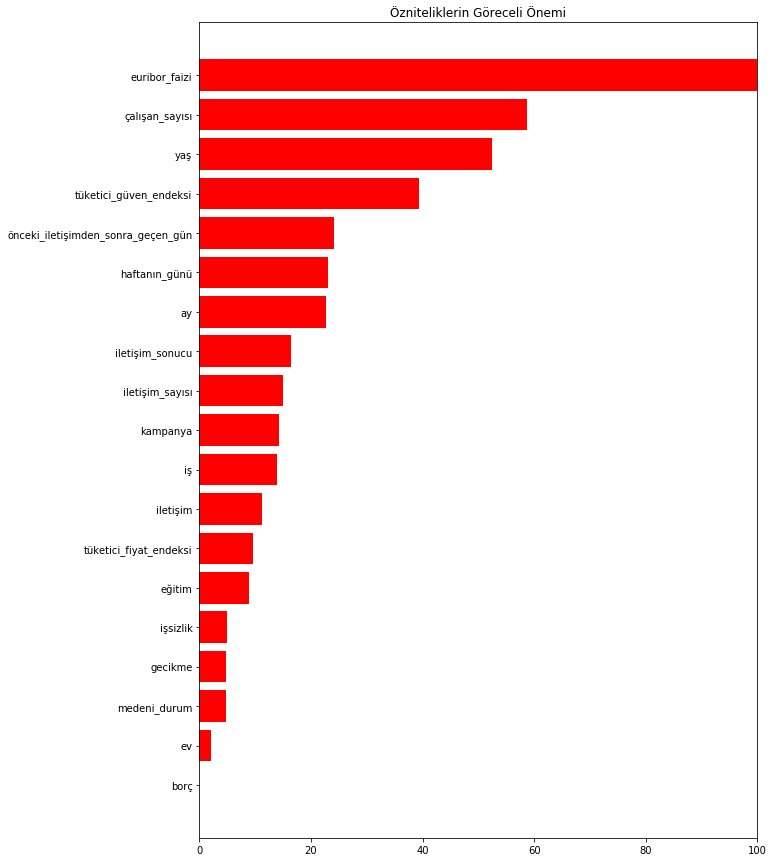

In [11]:
# Plot the feature importances of the forest
importances = gbc.feature_importances_ / gbc.feature_importances_.max() * 100
indices = np.argsort(importances)#[::-1]

plt.figure(figsize=(10,15))
plt.title("Özniteliklerin Göreceli Önemi")
plt.barh(range(df_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(df_train.shape[1]), df_train.columns[indices])
plt.xlim([0, 100])
plt.show()

`LightGBM` ile karşılaştırmak gerekirse `kampanya` değişkeninin öneminin azaldığını `çalışan_sayısı` değişkeninin ise öneminin arttığını görebiliriz.